<a href="https://colab.research.google.com/github/Kulikov17/MLDS_CV/blob/main/cars_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем dataset из kaggle

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle competitions download -c hse-cars-competition

100% 1.82G/1.82G [00:23<00:00, 116MB/s]
100% 1.82G/1.82G [00:23<00:00, 84.6MB/s]


In [ ]:
!unzip hse-cars-competition.zip

In [7]:
import pandas as pd
import numpy as np

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [8]:
RANDOM_SEED = 42

In [9]:
train_ann = pd.read_csv('./annotation/train_ann.csv')

In [11]:
train_ann.sample(3)

,imname,class
3622,train/cb9523dc0eb59bad8b51e36a579fc9f0.jpg,54
326,train/6ff1566adbf82797ffc229bfb7801cfc.jpg,139
7247,train/c96d00eb46764bd483a13638975ecc1e.jpg,131


In [15]:
plot_data = train_ann.groupby(['class'])['class'].count().to_frame('count')

In [29]:
plot_data['count'].min()

24

In [30]:
plot_data['count'].max()

68

In [33]:
plot_data['count'].mean()

41.48979591836735

<ipython-input-20-89dd7cb67e5e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='class', y='count', data=plot_data, palette='viridis')


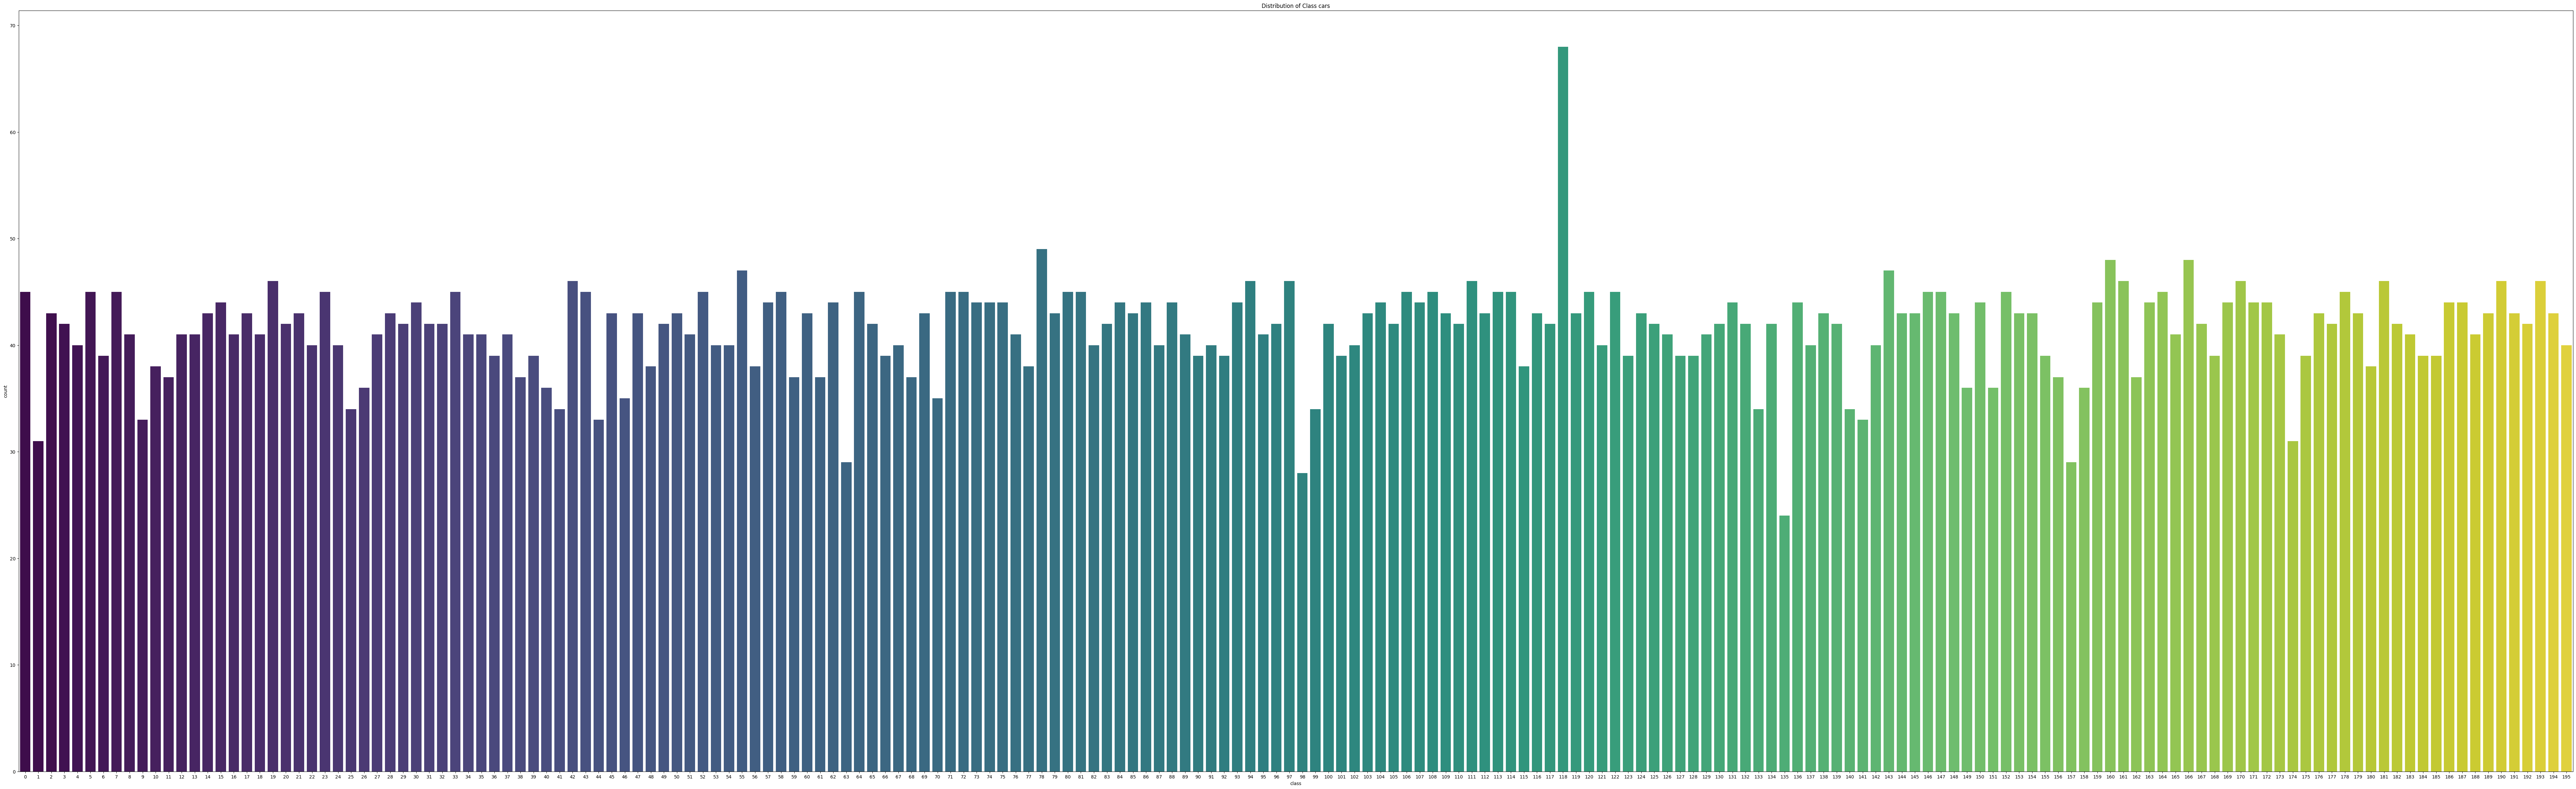

In [20]:
plt.figure(figsize=(100, 30))

ax = sns.barplot(x='class', y='count', data=plot_data, palette='viridis')

plt.xlabel('class')
plt.ylabel('count')
plt.title('Distribution of Class cars')

plt.show()

Наблюдаем что классы несбалансированы, особенно класс 118

Идея попробовать сбалансировать датасет по минимальной шкале и обучить модель


In [84]:
def balanced_annotation(ann, max_count):
  class_dict = {}
  b_ann = pd.DataFrame()

  for i in range(len(ann)):
    impath, target = ann.loc[i]

    if target in class_dict:
      class_dict[target] += 1
    else:
      class_dict[target] = 1

    if class_dict[target] <= max_count:
      new_row = pd.DataFrame({'imname': impath, 'class': target}, index=[0])
      b_ann = pd.concat([b_ann.loc[:], new_row]).reset_index(drop=True)

  return b_ann


In [85]:
train_ann_b = balanced_annotation(train_ann, 24)

In [87]:
def train_test_split_annotation(ann, max_count, percent):
  class_dict = {}
  train_ann = pd.DataFrame()
  test_ann = pd.DataFrame()

  for i in range(len(ann)):
    impath, target = ann.loc[i]

    if target in class_dict:
      class_dict[target] += 1
    else:
      class_dict[target] = 1

    new_row = pd.DataFrame({'imname': impath, 'class': target}, index=[0])

    if class_dict[target] / max_count < percent:
      train_ann = pd.concat([train_ann.loc[:], new_row]).reset_index(drop=True)
    else:
      test_ann = pd.concat([test_ann.loc[:], new_row]).reset_index(drop=True)


  return train_ann, test_ann


In [94]:
train_ann_b, val_ann_b = train_test_split_annotation(train_ann_b, 24, 0.8)

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
from PIL import Image

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
device

device(type='cpu')

In [52]:
data_transforms = transforms.Compose([
  transforms.Resize(256),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [95]:
class CarsDataset(Dataset):
    """Cars dataset."""

    def __init__(self, root_dir, imlist, transform=None):
        """
        Arguments:
            imlist(pandas DataFrame): DataFrame with columns file_name, class
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.imlist = imlist
        self.transform = transform

    def __len__(self):
        return len(self.imlist)

    def __getitem__(self, idx):
        impath, target = self.imlist.loc[idx]
        full_imname = os.path.join(self.root_dir, impath)

        if not os.path.exists(full_imname):
            print('No file ', full_imname)
            pass

        img = Image.open(full_imname).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, target

In [110]:
train_set = CarsDataset('./images', train_ann_b, transform=data_transforms)
val_set = CarsDataset('./images', val_ann_b, transform=data_transforms)

In [105]:
batch_size=32

In [111]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           num_workers=2,
                                           shuffle=True,
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=batch_size,
                                         num_workers=2,
                                         pin_memory=True)

In [107]:
## берем легкую сеть,
class EasyCNN(nn.Module):
    def __init__(self, n_classes):
        super(EasyCNN, self).__init__()

        self.conv_block = nn.Sequential(
          nn.Conv2d(3, 24, 3),
          nn.LeakyReLU(),
          nn.Conv2d(24, 12, 3),
          nn.LeakyReLU()
        )

        self.fc_layers = nn.Sequential(
          nn.Linear(12*44*44, n_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view((x.shape[0], -1)) #flatten
        x = self.fc_layers(x)

        return x

In [114]:
#сеть завели, на GPU положили
net = EasyCNN(n_classes=196).to(device)

#гиперпараметры завели
lr = 3e-4 #choose
num_epochs = 5 #choose no more than 10

#loss функцию, оптимайзер выбрали
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr) #choose

In [112]:
def run_epoch(epoch, is_train):
  """
  Training and evaluaton loop over samples
  Args:
      train_mode (bool): True for train mode
  """
  if is_train:
      net.train()
      loader = train_loader
      print("Training epoch: ", epoch + 1, "/", num_epochs)
  else:
      net.eval()
      loader = val_loader
      print('Validation')

  running_loss = 0.0
  correct = 0.0
  total = 0.0

  for i, data in enumerate(loader):
      # берем батч, кладем на GPU
      images, labels, _= data
      images, labels = images.cuda(), labels.cuda()

      #мы всегда прогоняем батч через сеть и считаем loss
      outputs = net(images)
      loss = criterion(outputs, labels)

      #занулять градиенты, считать новые, обновлять веса - всё нужно только на обучении
      if is_train:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      #пополняем логи
      running_loss += loss.item()
      total += images.data.size(0)

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels.data).sum()

  #после эпохи или валидации логируем
  print('Loss: {:.3f}, accuracy: {:.3f}'.format(running_loss / (i + 1), correct / total * 100.0))

In [113]:
#а теперь просто запускаем функцию с разными значениями is_train для каждой эпохи
%%time
for epoch in range(num_epochs):
  #training
  run_epoch(epoch, is_train=True)

  #validation
  with torch.no_grad():
      run_epoch(epoch, is_train=False)

  print('----------------------')

print('Finished training! Enjoy your results!')

Training epoch:  1 / 5


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 256, 341] at entry 0 and [3, 256, 320] at entry 1
